
# Part 2: Sentiment Analysis — Google Play Store User Reviews

- Analyze the distribution of sentiments in the reviews dataset using raw data and a specialized sentiment model (VADER)  
- Compare LLM-based sentiment analysis on a random sample of reviews  
- Provide insights in the **Application catalog / IT landscape** context

---

In [ ]:
import os
import tqdm 
import dotenv
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Callable, Union, Literal
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

dotenv.find_dotenv()    # Load environment variables from .env file

'/mnt/c/Users/Gaurav/Desktop/Work/Interview/SAP/Assignment/SentimentAnalysis/.env'

### Data preprocessing

In [274]:
# Load the dataset
reviews = pd.read_csv("data/input/googleplaystore_user_reviews.csv")

# Convert column names to lowercase and remove spaces
reviews.columns = [c.strip().lower().replace(" ", "_") for c in reviews.columns]

# Drop rows with missing 'translated_review' values
reviews_clean = reviews.dropna(subset=['translated_review']).copy()
reviews_clean.reset_index(drop=True, inplace=True)  # Reset index to avoid issues with dropped rows

# View the first few rows of the cleaned dataset
reviews_clean.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
4,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [275]:
reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37427 entries, 0 to 37426
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   app                     37427 non-null  object 
 1   translated_review       37427 non-null  object 
 2   sentiment               37427 non-null  object 
 3   sentiment_polarity      37427 non-null  float64
 4   sentiment_subjectivity  37427 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.4+ MB


In [276]:
reviews_clean.groupby(['app']).size()

app
10 Best Foods for You                                 194
104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室                       40
11st                                                   39
1800 Contacts - Lens Store                             80
1LINE – One Line with One Touch                        38
                                                     ... 
Hotels.com: Book Hotel Rooms & Find Vacation Deals     68
Hotspot Shield Free VPN Proxy & Wi-Fi Security         34
Hotstar                                                32
Hotwire Hotel & Car Rental App                         33
Housing-Real Estate & Property                         21
Length: 865, dtype: int64

### Data visualization and Analysis

In [277]:
# Filter review data to include at-least 50 reviews per app
min_reviews = 50
reviews_filter = (reviews.groupby(['app']).size()   # Group by app and count the number of reviews
                  [reviews.groupby(['app']).size() > min_reviews]   # Filter to include only apps with at least min_reviews number of reviews
                  .reset_index())   # Reset index to convert the Series back into a DataFrame

# Apply filter to dataframe
reviews_filtered = reviews[reviews.app.isin(reviews_filter.app)]

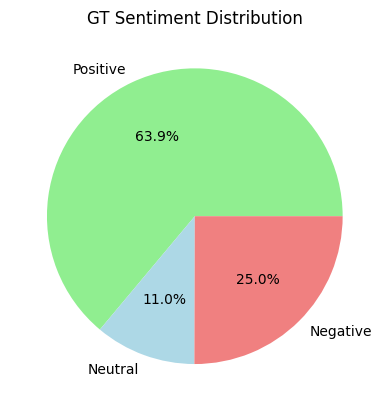

In [278]:
# Visualize the Distribution Pie plot
plot_df_gt = reviews_filtered['sentiment'].value_counts(normalize=True)
plt.pie([plot_df_gt.get(s,0) for s in ('Positive','Neutral','Negative')], autopct='%1.1f%%', labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title("GT Sentiment Distribution")
plt.show()

--------Top 5 positive sentiment Apps-----------
app
Helix Jump                        209
Duolingo: Learn Languages Free    200
Calorie Counter - Macros          174
Bowmasters                        169
Calorie Counter - MyFitnessPal    169
dtype: int64
--------Top 5 Negative sentiment Apps-----------
app
Angry Birds Classic      147
Candy Crush Saga         126
Bowmasters               119
8 Ball Pool              106
Candy Crush Soda Saga     96
dtype: int64


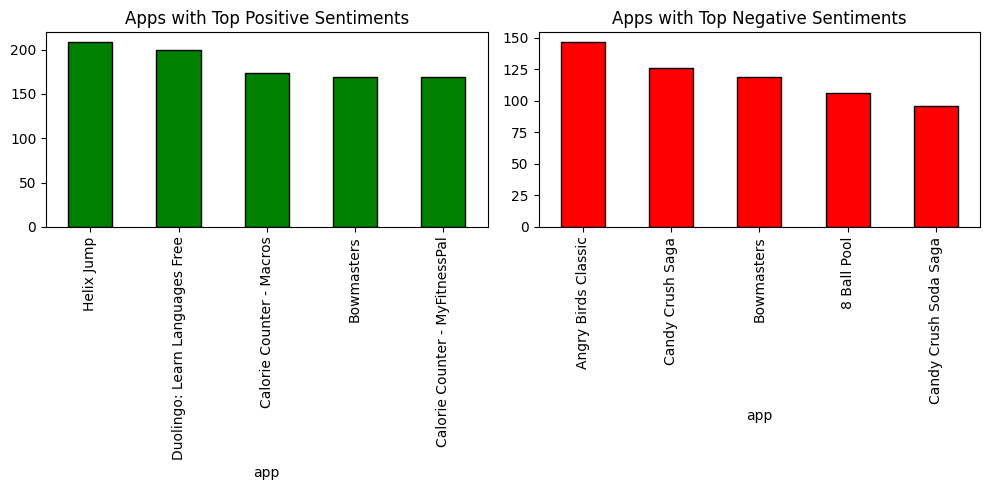

In [279]:
# Prepare dataset for plotting
apps_pos_sentiments = reviews_filtered[reviews_filtered.sentiment == 'Positive'].groupby(['app']).size().sort_values(ascending=False)
app_neu_sentiments= reviews_filtered[reviews_filtered.sentiment == 'Neutral'].groupby(['app']).size().sort_values(ascending=False)
app_neg_sentiments = reviews_filtered[reviews_filtered.sentiment == 'Negative'].groupby(['app']).size().sort_values(ascending=False)

# Check top 5 apps with maximum positive and negative sentiment
print(
    "--------Top 5 positive sentiment Apps-----------",
    apps_pos_sentiments[:5], 
    "--------Top 5 Negative sentiment Apps-----------", 
    app_neg_sentiments[:5], 
    sep="\n"
    )

# Plot the top 5 apps with positive and negative sentiments
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
apps_pos_sentiments[:5].plot.bar(x='app', y='count', color='green', edgecolor='black', ax=axs[0], title='Apps with Top Positive Sentiments')
# axs[0].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
app_neg_sentiments[:5].plot.bar(x='app', y='count', color='red', edgecolor='black', ax=axs[1], title='Apps with Top Negative Sentiments')
# axs[1].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
fig.tight_layout() # Layout so plots do not overlap



Observations:
* Distribution of sentiments is balanced with a slight preference towards Positive sentiment followed by Negative and Neutral. 
* Positive Sentiments: The top positive sentiment apps are mostly games and productivity apps, indicating that users have a strong affinity for these types of content.
* Negative Sentiments: The top negative sentiment apps have less reviews than apps with positive sentiments, indicating that these apps are not as popular or well-received by users.  User's reviews suggests that they may be experiencing frustration or dissatisfaction with certain game mechanics or features.

Conclusion:

Users tend to have a positive sentiment towards apps that provide entertainment and productivity value, while those that fail to meet user expectations tend to receive negative reviews. These insights can inform app developers and marketers to create more engaging and satisfying experiences for users.

### Sentiment analysis

#### 1. Using VADER Score

In [280]:
# Download the VADER lexicon
# nltk.download('vader_lexicon')

# Create object of Sentiment analyzer
sid = SentimentIntensityAnalyzer()

sid.polarity_scores(str(x)) is from the vaderSentiment library (part of the NLTK toolkit) that calculates the sentiment scores of a given text.
It returns a dictionary with four keys:
* 'neg': The proportion of text that falls in the negative category.
* 'neu': The proportion of text that falls in the neutral category.
* 'pos': The proportion of text that falls in the positive category.
* 'compound': A score that calculates the sum of all lexicon ratings which have been normalized between -1 and +1. 

* *sentiment_polarity* weighted sum of all sentiment-bearing words in the text. However, *compound* the overall sentiment of the text by aggregating the lexicon ratings for each word and normalized between +1 and -1

In [281]:
# Compute sentiment scores and save in a new column
reviews_clean['vader_scores'] = reviews_clean['translated_review'].apply(lambda x: sid.polarity_scores(str(x)))
reviews_clean.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,vader_scores
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,"{'neg': 0.0, 'neu': 0.466, 'pos': 0.534, 'comp..."
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,"{'neg': 0.0, 'neu': 0.481, 'pos': 0.519, 'comp..."
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,"{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp..."
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,"{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp..."
4,10 Best Foods for You,Best way,Positive,1.00,0.300000,"{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp..."


In [282]:
# Remove existing 'vader_scores' column, split 'vadar_scores' column into 4 separate column and concatenate them to the DataFrame
reviews_clean = pd.concat([reviews_clean.drop(['vader_scores'], axis=1), pd.json_normalize(reviews_clean['vader_scores'])], axis=1)
reviews_clean.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,0.0,0.466,0.534,0.9531
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,0.0,0.481,0.519,0.6597
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,0.0,0.549,0.451,0.6249
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,0.0,0.323,0.677,0.6369
4,10 Best Foods for You,Best way,Positive,1.00,0.300000,0.0,0.192,0.808,0.6369


In [283]:
# Categorize sentiment
def vader_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment label to each compound score
reviews_clean['vader_sentiment'] = reviews_clean['compound'].apply(vader_label)

In [284]:
reviews_clean.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound,vader_sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,0.0,0.466,0.534,0.9531,positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,0.0,0.481,0.519,0.6597,positive
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,0.0,0.549,0.451,0.6249,positive
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,0.0,0.323,0.677,0.6369,positive
4,10 Best Foods for You,Best way,Positive,1.00,0.300000,0.0,0.192,0.808,0.6369,positive


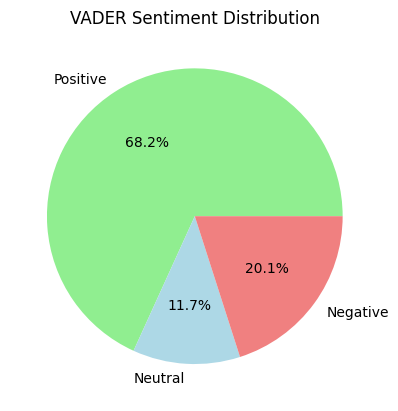

In [285]:
# Visualize the Distribution Pie plot
plot_df = reviews_clean['vader_sentiment'].value_counts(normalize=True)
# reviews_clean['vader_sentiment'].value_counts(normalize=True, sort=False).plot.pie(
#     autopct='%1.1f%%', colors=['lightgreen','lightcoral','lightblue'], title="VADER Sentiment Distribution"
# )
plt.pie([plot_df.get(s,0) for s in ('positive','neutral','negative')], autopct='%1.1f%%', labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title("VADER Sentiment Distribution")
plt.show()

--------Top 5 positive sentiment Apps-----------
app
Helix Jump                        234
Duolingo: Learn Languages Free    223
Bowmasters                        209
Calorie Counter - Macros          178
Candy Crush Saga                  168
Name: count, dtype: int64
--------Top 5 Negative sentiment Apps-----------
app
Angry Birds Classic    126
Bowmasters              97
Agar.io                 71
Garena Free Fire        69
Facebook                69
Name: count, dtype: int64


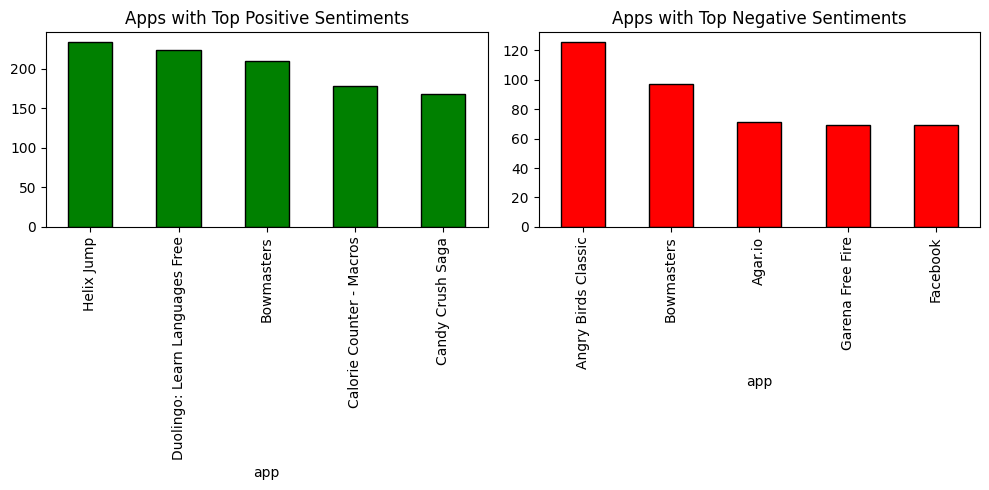

In [286]:
# Top 5 Apps with maximum positive sentiment
app_positive_sentiment = reviews_clean[reviews_clean['vader_sentiment'] == 'positive']['app'].value_counts()
app_negative_sentiment = reviews_clean[reviews_clean['vader_sentiment'] == 'negative']['app'].value_counts()

# Check top 5 apps with maximum positive and negative sentiment
print(
    "--------Top 5 positive sentiment Apps-----------",
    app_positive_sentiment[:5], 
    "--------Top 5 Negative sentiment Apps-----------", 
    app_negative_sentiment[:5], 
    sep="\n"
    )

# Plot the top 5 apps with positive and negative sentiments
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
app_positive_sentiment[:5].plot.bar(x='app', y='count', color='green', edgecolor='black', ax=axs[0], title='Apps with Top Positive Sentiments')
# axs[0].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
app_negative_sentiment[:5].plot.bar(x='app', y='count', color='red', edgecolor='black', ax=axs[1], title='Apps with Top Negative Sentiments')
# axs[1].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
fig.tight_layout() # Layout so plots do not overlap


**Findings:**  
- Majority of reviews are positive.  
- Neutral reviews form a smaller fraction.  
- Negative reviews are a minority but crucial for app assessment.

**IT context:**  
- Positive → apps performing well.  
- Negative → candidates for remediation, replacement, or decommissioning.  
- Neutral → generic feedback, may need further analysis.  


#### 2. Sentiment analysis using LLM 

2.1. Using OpenAI API

In [287]:
# API Key setup (interactive)
if 'OPENAI_API_KEY' not in os.environ:
    key = getpass("Enter your OpenAI API key (hidden): ")
    if key:
        os.environ['OPENAI_API_KEY'] = key
# openai.api_key = os.environ.get("OPENAI_API_KEY", "")

 # Initialize OpenAI client
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Function to classify with LLM
def sentiment_classification_openai(sample_reviews, model='gpt-4o-mini', temperature=0.0):
    labels = [] 
    # for t in tqdm.tqdm(texts, desc="Classifying sentiments"):
    for t in tqdm.tqdm(sample_reviews.iterrows(), desc="Classifying sentiments"):
        # Extract text
        text = t[1].translated_review
        
        # Creating prompt 
        prompt = f"Classify the sentiment of the following review into one of three labels: positive, neutral, negative.\n\nReview: {text}\nLabel:"
        
        # Invoking the model
        resp = client.responses.create(
            model=model,
            input=prompt,
            temperature=temperature
        )
        
        lbl = resp.output[0].content[0].text.strip().lower()
        if 'positive' in lbl:
            labels.append('positive')
        elif 'negative' in lbl:
            labels.append('negative')
        elif 'neutral' in lbl:
            labels.append('neutral')
        else:
            labels.append('unknown')
    return labels


2.2. Using LangChain

In [288]:
class SentimentSchema(BaseModel):
    """Schema for sentiment analysis"""

    sentiment: Literal["positive", "neutral", "negative"]  = Field(..., description="Sentiment of the review")
    score: float = Field(..., description="Sentiment score (0-1)")
    comments: str = Field(..., description="Comments")

# Create LLM
# llm = ChatOpenAI(
#     model="gpt-4o-mini", 
#     max_retries=2, 
#     temperature=0.0
#     )
llm = ChatOllama(
    base_url="localhost:11434",
    model="llama3.1:8b",
    temperature=0.0
)

# llm with structured output
llm = llm.with_structured_output(SentimentSchema)

# Create prompt for sentiment analysis
template = """
You are an expert analysis of customer reviews. 
Your task is to analyze the sentiment of a given review and provide a sentiment, score and small comment

Review:
{review}
"""
prompt = PromptTemplate(
    input_variables=["review"], 
    template=template, 
    validate_template=True
)

# Create sentiment analysis chain
sentiment_chain = prompt | llm

# Function to classify with LLM
def sentiment_classification_ollama(sample_reviews, llm_chain):
    labels = [] 
    for _, row in tqdm.tqdm(sample_reviews.iterrows(), desc="Classifying sentiments"):
        # Extract review text
        review = row.translated_review
                
        # Invoking the llm chain
        response = llm_chain.invoke({
            "review": review
            })
        # Appending sentiment to the labels list
        labels.append(response.sentiment)
    return labels

In [289]:
# Sample dataset
max_samples = 50
sample_reviews = reviews_clean.sample(max_samples, random_state=42)

# Predict sentiments using LLM
llm_labels = sentiment_classification_ollama(sample_reviews, sentiment_chain)
# llm_labels = sentiment_classification_openai(sample_reviews)

# Add new column of LLM sentiment prediction
sample_reviews['LLM_sentiment'] = llm_labels

Classifying sentiments: 50it [01:05,  1.32s/it]


In [290]:
reviews_clean['vader_sentiment'].value_counts(normalize=True, sort=False), sample_reviews['LLM_sentiment'].value_counts(normalize=True, sort=False)

(vader_sentiment
 positive    0.682021
 neutral     0.117455
 negative    0.200524
 Name: proportion, dtype: float64,
 LLM_sentiment
 negative    0.42
 neutral     0.08
 positive    0.50
 Name: proportion, dtype: float64)

### Evaluation of the sentiment analysis from VADER and LLM

In [291]:
# # Visualize the Distribution Pie plot
# plot_df = sample_reviews['LLM_sentiment'].value_counts(normalize=True)
# plt.pie([plot_df.get(s,0) for s in ('positive','neutral','negative')], autopct='%1.1f%%', labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'])
# plt.title("LLM Sentiment Distribution")
# plt.show()

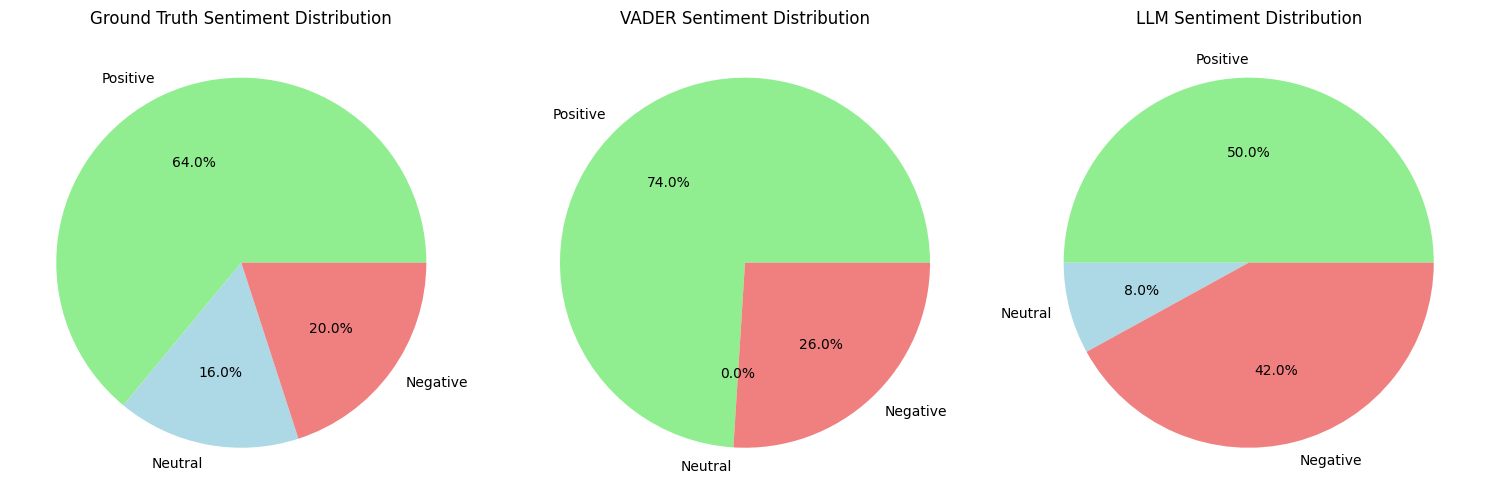

In [292]:
# Visualize the Distribution Pie plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot LLM sentiment distribution on first subplot
plot_df_gt = sample_reviews['sentiment'].value_counts(normalize=True)
axs[0].pie([plot_df_gt.get(s,0) for s in ['Positive', 'Neutral', 'Negative']], labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'], autopct='%1.1f%%')
axs[0].set_title("Ground Truth Sentiment Distribution")

# # Plot Vader sentiment distribution on second subplot
plot_df_vader = sample_reviews['vader_sentiment'].value_counts(normalize=True)
axs[1].pie([plot_df_vader.get(s,0) for s in ['positive', 'neutral', 'negative']], labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'], autopct='%1.1f%%')
axs[1].set_title("VADER Sentiment Distribution")

# # Plot GT sentiment distribution on third subplot
plot_df_llm = sample_reviews['LLM_sentiment'].value_counts(normalize=True)
axs[2].pie([plot_df_llm.get(s,0) for s in ['positive', 'neutral', 'negative']], labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'], autopct='%1.1f%%')
axs[2].set_title("LLM Sentiment Distribution")

plt.tight_layout()
plt.show()

Calculate the Precision, Recall, and F1 Score for Vader and LLM based sentiment analysis

In [ ]:
# Calculate precision, recall, and F1 score for VADER and LLM sentiment analysis

# For Vader method
tp_vader = len(sample_reviews[(sample_reviews['sentiment'] == 'Positive') & (sample_reviews['vader_sentiment'] == 'positive')])
fp_vader = len(sample_reviews[(sample_reviews['sentiment'] != 'Positive') & (sample_reviews['vader_sentiment'] == 'positive')])
fn_vader = len(sample_reviews[(sample_reviews['sentiment'] == 'Negative') & (sample_reviews['vader_sentiment'] == 'negative')])

# Calculate f1 score
precision_vader = tp_vader / (tp_vader + fp_vader)
recall_vader = tp_vader / (tp_vader + fn_vader)
f1_vader = 2 * precision_vader * recall_vader / (precision_vader + recall_vader)

# For LLM method
tp_llm = len(sample_reviews[(sample_reviews['sentiment'] == 'Positive') & (sample_reviews['LLM_sentiment'] == 'positive')])
fp_llm = len(sample_reviews[(sample_reviews['sentiment'] != 'Positive') & (sample_reviews['LLM_sentiment'] == 'positive')])
fn_llm = len(sample_reviews[(sample_reviews['sentiment'] == 'Negative') & (sample_reviews['LLM_sentiment'] == 'negative')])

# Calculate f1 score
precision_llm = tp_llm / (tp_llm + fp_llm)
recall_llm = tp_llm / (tp_llm + fn_llm)
f1_llm = 2 * precision_llm * recall_llm / (precision_llm + recall_llm)

print(f"VADER Precision:{precision_vader:.2f}")
print(f"VADER Recall:{recall_vader:.2f}")
print(f"VADER F1 score:{f1_vader:.2f}")

print(f"\nLLM Precision:{precision_llm:.2f}")
print(f"LLM Recall:{recall_llm:.2f}")
print(f"LLM F1 score:{f1_llm:.2f}")

VADER Precision:0.78
VADER Recall:0.81
VADER F1 score:0.79

LLM Precision:0.84
LLM Recall:0.75
LLM F1 score:0.79



**Observation:**  
- LLM-based sentiment provides better contextual understanding than lexicon-based methods.  
- Recommended to use VADER for bulk processing; validate or spot-check critical apps with LLM.  
- Compare VADER vs LLM labels on the sample to compute agreement and discrepancies.
- LLM based sentiment analysis perform better than lexicon-based methods, evident from F1 score.  



# Summary

1. **High positive sentiment apps** → stable, low-risk in IT portfolio.  
2. **High negative sentiment apps** → candidates for remediation, replacement, or decommissioning.  
3. **VADER vs LLM** → lexicon model is fast; LLM is more accurate for nuanced sentiment but it is expensive.  
4. **Distribution analysis** → helps prioritize attention:  
   - High installs + high negative sentiment → critical remediation.  
   - Low installs + negative sentiment → candidate for decommission.

---